Notebook 10: MLflow Tracking con Experimentos y Artefactos

In [1]:
# # Notebook 10: MLflow Tracking
# **Objetivo**: Implementar el ciclo de vida de experimentos para el modelo SECOP.

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.sql.functions import col, when
import mlflow
import mlflow.spark
import pandas as pd
import matplotlib.pyplot as plt

# %%
spark = SparkSession.builder \
    .appName("SECOP_MLflow_Tracking") \
    .master("spark://spark-master:7077") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/15 18:12:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



## RETO 1: Configurar MLflow
 **Pregunta**: ¿Por qué un servidor centralizado? 
 **Respuesta**: Porque permite la colaboración, mantiene un historial inmutable y 
 facilita el despliegue a producción (Model Registry) sin buscar archivos locales perdidos.



In [ ]:
# Configurar conexión al servidor de MLflow
mlflow.set_tracking_uri("http://mlflow:5000")
experiment_name = "/SECOP_Clasificacion_Contratos"
mlflow.set_experiment(experiment_name)

print(f"Tracking URI: {mlflow.get_tracking_uri()}")

# Preparación de datos (Top 25%)
df_raw = spark.read.parquet("/opt/spark-data/processed/secop_ml_ready.parquet")
discretizer = QuantileDiscretizer(numBuckets=4, inputCol="label", outputCol="cuartil")
df_final = discretizer.fit(df_raw).transform(df_raw) \
    .withColumn("label", when(col("cuartil") == 3.0, 1.0).otherwise(0.0)) \
    .select("features", "label")

train, test = df_final.randomSplit([0.8, 0.2], seed=42)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")


Tracking URI: http://mlflow:5000


## RETO 2: Registrar Experimento Baseline


In [3]:
with mlflow.start_run(run_name="Logistic_Baseline"):
    # 1. Parámetros
    reg_param = 0.0
    mlflow.log_param("regParam", reg_param)
    mlflow.log_param("model_type", "LogisticRegression")
    
    # 2. Entrenar
    lr = LogisticRegression(regParam=reg_param, labelCol="label")
    model = lr.fit(train)
    
    # 3. Métricas
    auc = evaluator.evaluate(model.transform(test))
    mlflow.log_metric("auc", auc)
    
    # 4. Modelo
    mlflow.spark.log_model(model, "model")
    
    print(f"Baseline AUC: {auc:.4f}")

2026/02/15 18:12:31 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

26/02/15 18:12:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBL

Baseline AUC: 0.8262


## RETO 3: Registrar Múltiples Modelos (Ridge, Lasso, ElasticNet)


In [4]:
configs = [
    {"name": "Ridge_L2", "reg": 0.1, "elastic": 0.0},
    {"name": "Lasso_L1", "reg": 0.1, "elastic": 1.0},
    {"name": "ElasticNet_50", "reg": 0.1, "elastic": 0.5}
]

for conf in configs:
    with mlflow.start_run(run_name=conf["name"]):
        lr = LogisticRegression(regParam=conf["reg"], elasticNetParam=conf["elastic"], labelCol="label")
        model = lr.fit(train)
        
        # Log Parámetros
        mlflow.log_params({
            "regParam": conf["reg"],
            "elasticNetParam": conf["elastic"],
            "maxIter": 100
        })
        
        # Log Métricas
        auc = evaluator.evaluate(model.transform(test))
        mlflow.log_metric("auc", auc)
        
        # Log Modelo
        mlflow.spark.log_model(model, "model")
        print(f"Run {conf['name']} completado. AUC: {auc:.4f}")


2026/02/15 18:12:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpv2mgkxi2/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.


Run Ridge_L2 completado. AUC: 0.8259


2026/02/15 18:13:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9w18la0i/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.


Run Lasso_L1 completado. AUC: 0.7918


2026/02/15 18:13:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpikxpqjo5/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.


Run ElasticNet_50 completado. AUC: 0.7982


## RETO 5: Agregar Artefactos Personalizados



2026/02/15 18:13:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyjt7_dyo/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.


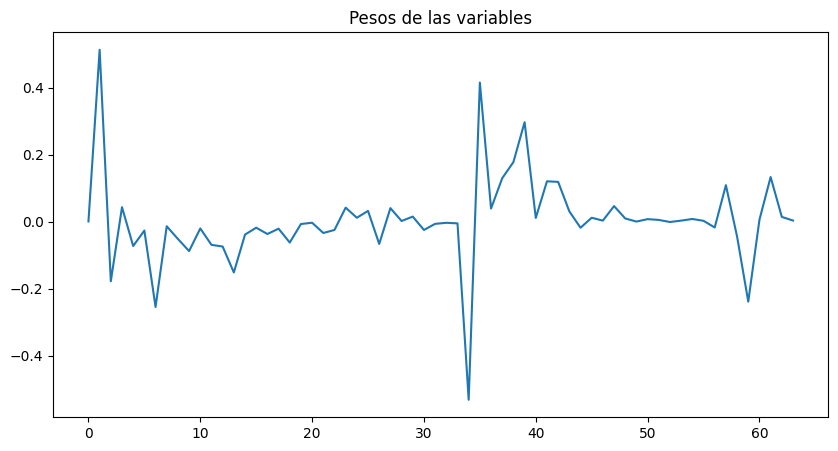

In [ ]:

with mlflow.start_run(run_name="Final_Model_With_Artifacts"):
    # Usamos el mejor parámetro encontrado antes (Ridge 0.01)
    lr = LogisticRegression(regParam=0.01, elasticNetParam=0.0, labelCol="label")
    model = lr.fit(train)
    auc = evaluator.evaluate(model.transform(test))
    
    # 1. Guardar Reporte de Texto
    report = f"Resumen de Modelo SECOP\nAUC Final: {auc:.4f}\nEstado: Listo para Producción"
    mlflow.log_text(report, "final_report.txt")
    
    # 2. Guardar Gráfico de Importancia (Simulado)
    coefs = model.coefficients.toArray()
    plt.figure(figsize=(10,5))
    plt.plot(coefs)
    plt.title("Pesos de las variables")
    plt.savefig("feature_weights.png")
    mlflow.log_artifact("feature_weights.png")
    
    mlflow.log_metric("auc", auc)
    mlflow.spark.log_model(model, "model")


spark.stop()

## Preguntas de Reflexión
1. **Ventajas sobre CSV**: Búsqueda avanzada, almacenamiento de archivos de modelo, trazabilidad de quién y cuándo entrenó, y visualización de curvas.
2. **Implementación en equipo**: Usando un servidor central (PostgreSQL para métricas y S3/MinIO para artefactos).
3. **Artefactos adicionales**: Curvas ROC, matrices de confusión, y esquemas de datos (JSON).
